# Using boost-histogram


In [1]:
import boost_histogram as bh
import numpy as np
import matplotlib.pyplot as plt
import functools
import operator

## 1: Basic 1D histogram

Let's start with the basics. We will create a histogram using boost-histogram and fill it.

### 1.1: Data

Let's make a 1d dataset to run on.

In [2]:
data1 = np.random.normal(3.5, 2.5, size=1_000_000)

Now, let's make a histogram

In [3]:
hist1 = bh.Histogram(bh.axis.Regular(40, -2, 10))

In [4]:
hist1.fill(data1)

Histogram(Regular(40, -2, 10), storage=Double()) # Sum: 981542.0 (1000000.0 with flow)

You can see that the histogram has been filled. Let's explicitly check to see how many entries are in the histogram:

In [5]:
hist1.sum()

981542.0

What happened to the missing items? They are in the underflow and overflow bins:

In [6]:
hist1.sum(flow=True)

1000000.0

Like ROOT, we have overflow bins by default. We can turn them off, but they enable some powerful things like projections.

Let's plot this (Hist should make this easier):

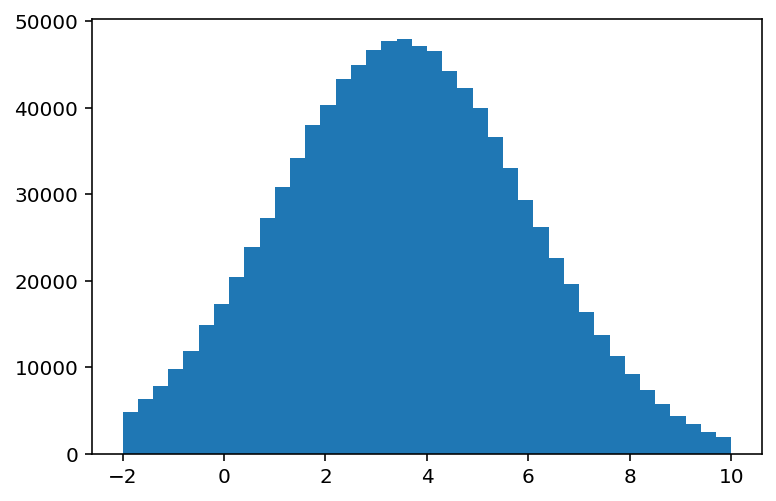

In [7]:
plt.bar(hist1.axes[0].centers, hist1.values(), width=hist1.axes[0].widths);

Note: you can select the axes before or after calling `.centers`; this is very useful for ND histograms.

From now on, let's be lazy

In [8]:
plothist = lambda h: plt.bar(*h.axes.centers, h.values(), width=h.axes.widths[0]);

Aside: here's step.  The edges are quite ugly for us, just like it is for numpy. Or anyone.

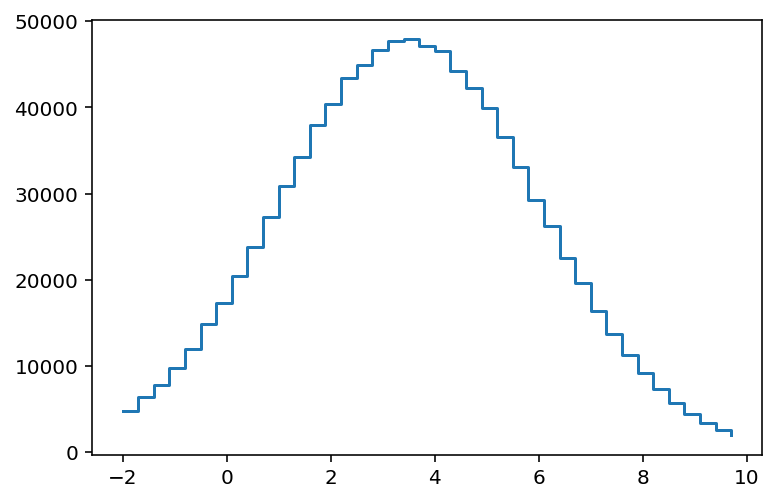

In [9]:
plt.step(hist1.axes[0].edges[:-1], hist1.values(), where="post");

Recent versions of matplotlib support `.stairs`, which was designed to work well with histograms:

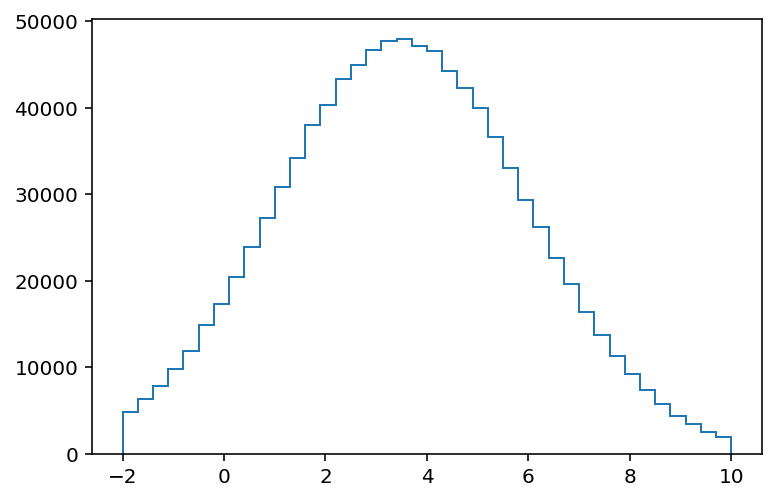

In [10]:
plt.stairs(hist1.values(), hist1.axes[0].edges);

No plotting is built in, but the data is easy to access.

## 2: Drop-in replacement for NumPy

To start using this yourself, you don't even need to change your code. Let's try the numpy adapters.

In [11]:
bins2, edges2 = bh.numpy.histogram(data1, bins=10)

In [12]:
b2, e2 = np.histogram(data1, bins=10)

In [13]:
bins2 - b2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [14]:
e2 - edges2

array([ 0.00000000e+00,  8.88178420e-16,  8.88178420e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.77635684e-15,  3.55271368e-15,
        0.00000000e+00,  0.00000000e+00, -1.77635684e-15])

Not bad! Let's start moving to the boost-histogram API, so we can use our little plotting function:

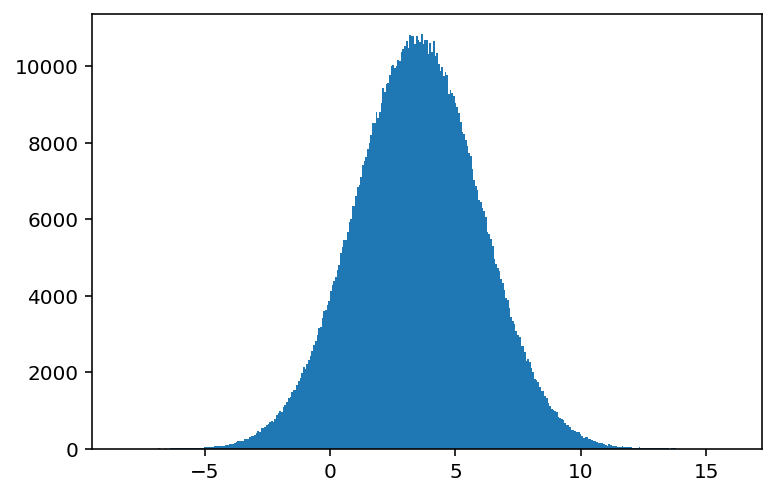

In [15]:
hist2 = bh.numpy.histogram(data1, bins="auto", histogram=bh.Histogram)
plothist(hist2);

Now we can move over to boost-histogram one step at a time! Just to be complete, we can also go back to a NumPy tuple from a Histogram object:

In [16]:
b2p, e2p = bh.numpy.histogram(data1, bins=10, histogram=bh.Histogram).to_numpy()
b2p == b2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## 3: More dimensions

The same API works for multiple dimensions.

In [17]:
hist3 = bh.Histogram(bh.axis.Regular(150, -1.5, 1.5), bh.axis.Regular(100, -1, 1))

In [18]:
def make_2D_data(*, mean=(0, 0), widths=(1, 1), size=1_000_000):
    cov = np.asarray(widths) * np.eye(2)
    return np.random.multivariate_normal(mean, cov, size=size).T

In [19]:
data3x = make_2D_data(mean=[-0.75, 0.5], widths=[0.2, 0.02])
data3y = make_2D_data(mean=[0.75, 0.5], widths=[0.2, 0.02])

From here on out, I will be using `.reset()` before a `.fill()`, just to make sure each cell in the notebook can be rerun.

In [20]:
hist3.reset()
hist3.fill(*data3x)
hist3.fill(*data3y)

Histogram(
  Regular(150, -1.5, 1.5),
  Regular(100, -1, 1),
  storage=Double()) # Sum: 1905785.0 (2000000.0 with flow)

Again, let's make plotting a little function:

In [21]:
def plothist2d(h):
    return plt.pcolormesh(*h.axes.edges.T, h.values().T)

This is transposed because `pcolormesh` [expects it](https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.pcolormesh.html#axes-pcolormesh-grid-orientation).

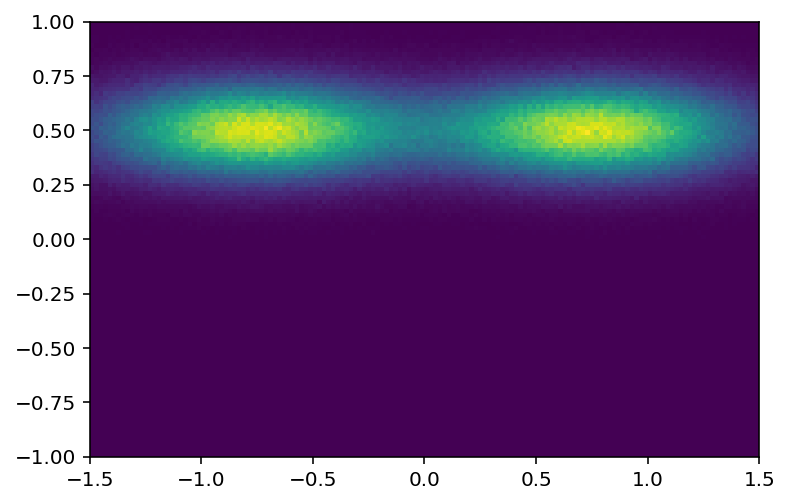

In [22]:
plothist2d(hist3);

Let's try a 3D histogram

In [23]:
data3d = [np.random.normal(size=1_000_000) for _ in range(3)]

hist3d = bh.Histogram(
    bh.axis.Regular(150, -5, 5),
    bh.axis.Regular(100, -5, 5),
    bh.axis.Regular(100, -5, 5),
)

hist3d.fill(*data3d)

Histogram(
  Regular(150, -5, 5),
  Regular(100, -5, 5),
  Regular(100, -5, 5),
  storage=Double()) # Sum: 1000000.0

Let's project to the first two axes:

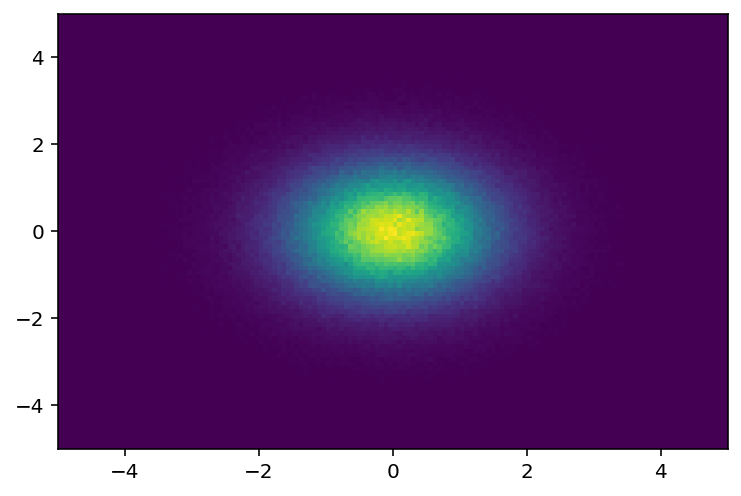

In [24]:
plothist2d(hist3d.project(0, 1));

## 4: UHI

Let's explore the boost-histogram UHI syntax. We will reuse the previous 2D histogram from part 3:

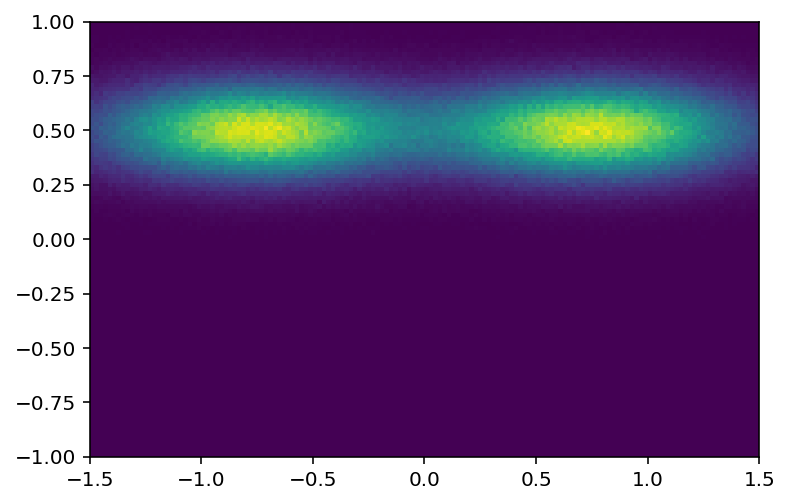

In [25]:
plothist2d(hist3);

I can see that I want y from 0.25 to 0.75, in data coordinates:

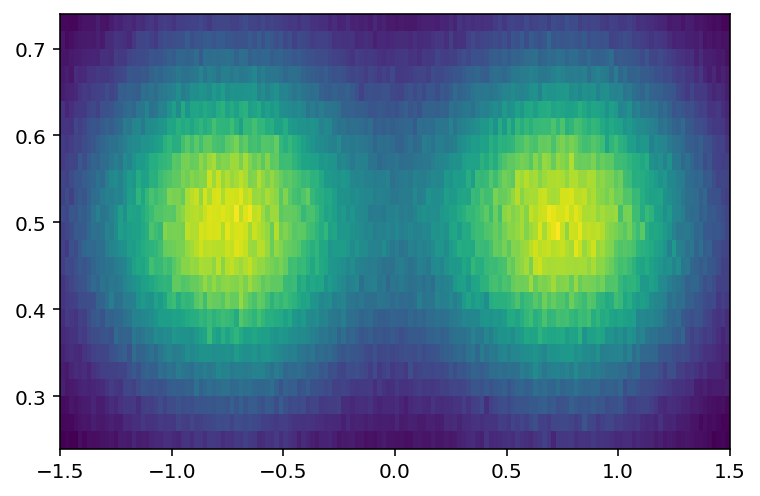

In [26]:
plothist2d(hist3[:, bh.loc(0.25) : bh.loc(0.75)]);

What's the contents of a bin?

In [27]:
hist3[100, 87]

181.0

How about in data coordinates?

In [28]:
hist3[bh.loc(0.5), bh.loc(0.75)]

181.0

> Note: to get the coordinates manually:
> 
> ```python
hist3.axes[0].index(.5) == 100
hist3.axes[1].index(.75) == 87
```

How about a 1d histogram?

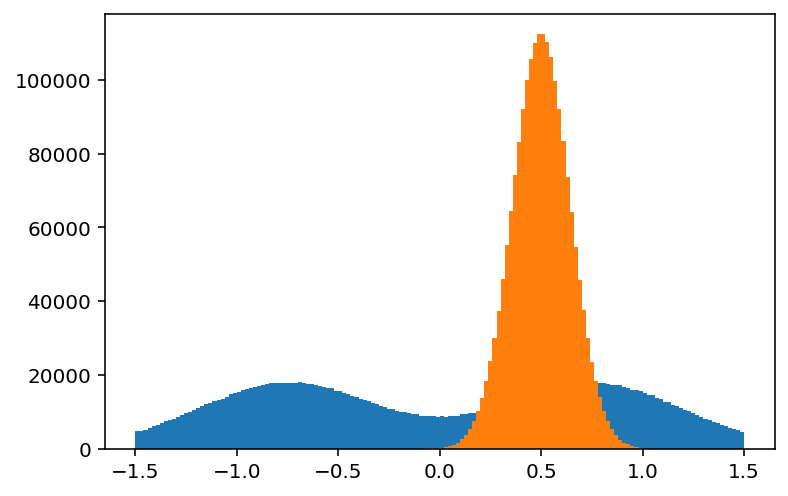

In [29]:
plothist(hist3[:, :: bh.sum])
plothist(hist3[:: bh.sum, :]);

Let's look at one part and rebin:

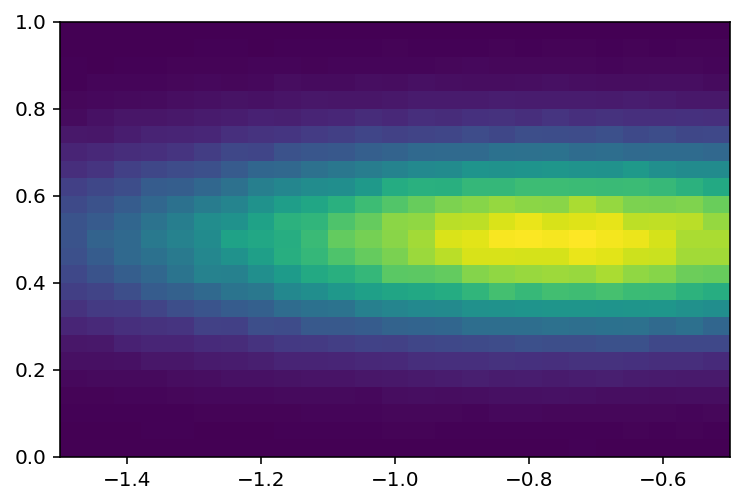

In [30]:
plothist2d(hist3[: 50 : bh.rebin(2), 50 :: bh.rebin(2)]);

What is the value at `(-.75, .5)`?

In [31]:
hist3[bh.loc(-0.75), bh.loc(0.5)]

1005.0

## 5: Understanding accumulators

Boost-histogram has several different storages; storages store accumulators. Let's try making a profile.

In [32]:
mean = bh.accumulators.Mean()
mean.fill([0.3, 0.4, 0.5])

Mean(count=3, value=0.4, variance=0.01)

Here's a quick example accessing the values:

In [33]:
print(
    f"mean.count={mean.count} mean.value={mean.value:g} mean.variance={mean.variance:g}"
)

# Python 3.8:
# print(f"{mean.count=} {mean.value=} {mean.variance=}")

mean.count=3.0 mean.value=0.4 mean.variance=0.01


## 6: Changing the storage

In [34]:
hist6 = bh.Histogram(bh.axis.Regular(10, 0, 10), storage=bh.storage.Mean())

In [35]:
hist6.fill([0.5] * 3, sample=[0.3, 0.4, 0.5])

Histogram(Regular(10, 0, 10), storage=Mean()) # Sum: Mean(count=3, value=0.4, variance=0.01)

In [36]:
hist6[0]

Mean(count=3, value=0.4, variance=0.01)

In [37]:
hist6.view()

MeanView(
      [(3., 0.4, 0.02), (0., 0. , 0.  ), (0., 0. , 0.  ), (0., 0. , 0.  ),
       (0., 0. , 0.  ), (0., 0. , 0.  ), (0., 0. , 0.  ), (0., 0. , 0.  ),
       (0., 0. , 0.  ), (0., 0. , 0.  )],
      dtype=[('count', '<f8'), ('value', '<f8'), ('_sum_of_deltas_squared', '<f8')])

In [38]:
hist6.view().value

array([0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [39]:
hist6.view().variance

array([ 0.01, -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.  ])

## 7: Making a density histogram

Let's try to make a density histogram like NumPy's.

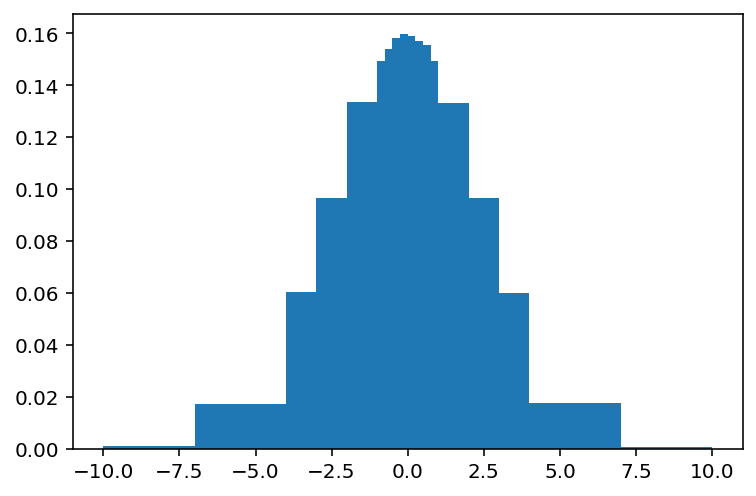

In [40]:
bins = [
    -10,
    -7,
    -4,
    -3,
    -2,
    -1,
    -0.75,
    -0.5,
    -0.25,
    0,
    0.25,
    0.5,
    0.75,
    1,
    2,
    3,
    4,
    7,
    10,
]
d7, e7 = np.histogram(data1 - 3.5, bins=bins, density=True)
plt.hist(data1 - 3.5, bins=bins, density=True);

Yes, it's ugly. Don't judge.

We don't have a `.density`! What do we do? (note: `density=True` is supported if you do not return a bh object)

In [41]:
hist7 = bh.numpy.histogram(data1 - 3.5, bins=bins, histogram=bh.Histogram)

widths = hist7.axes.widths
area = functools.reduce(operator.mul, hist7.axes.widths)

area

array([3.  , 3.  , 1.  , 1.  , 1.  , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 1.  , 1.  , 1.  , 3.  , 3.  ])

Yes, that does not need to be so complicated for 1D, but it's general.

In [42]:
factor = np.sum(hist7.values())
view = hist7.values() / (factor * area)

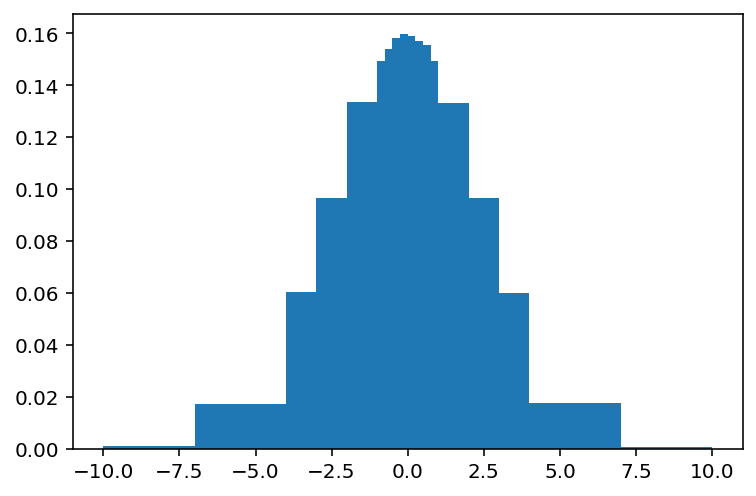

In [43]:
plt.bar(hist7.axes[0].centers, view, width=hist7.axes[0].widths);

## 8: Axis types

There are more axes types, and they all provide the same API in histograms, so they all just work without changes:

In [44]:
hist8 = bh.Histogram(
    bh.axis.Regular(30, 1, 10, transform=bh.axis.transform.log),
    bh.axis.Regular(30, 1, 10, transform=bh.axis.transform.sqrt),
)

In [45]:
hist8.reset()
hist8.fill(*make_2D_data(mean=(5, 5), widths=(5, 5)))

Histogram(
  Regular(30, 1, 10, transform=log),
  Regular(30, 1, 10, transform=sqrt),
  storage=Double()) # Sum: 903807.0 (1000000.0 with flow)

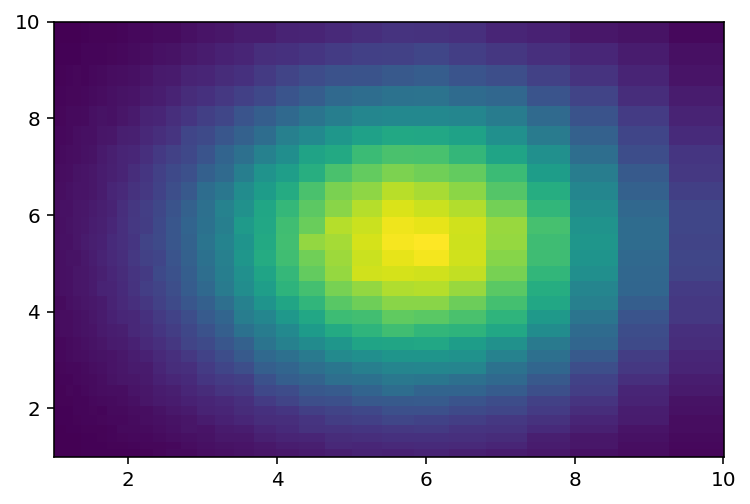

In [46]:
plothist2d(hist8);

## 9: And, circular, too!

In [47]:
hist9 = bh.Histogram(bh.axis.Regular(30, 0, 2 * np.pi, circular=True))
hist9.fill(np.random.uniform(0, np.pi * 4, size=300))

Histogram(Regular(30, 0, 6.28319, circular=True), storage=Double()) # Sum: 300.0

Now, the really complicated part, making a circular histogram:


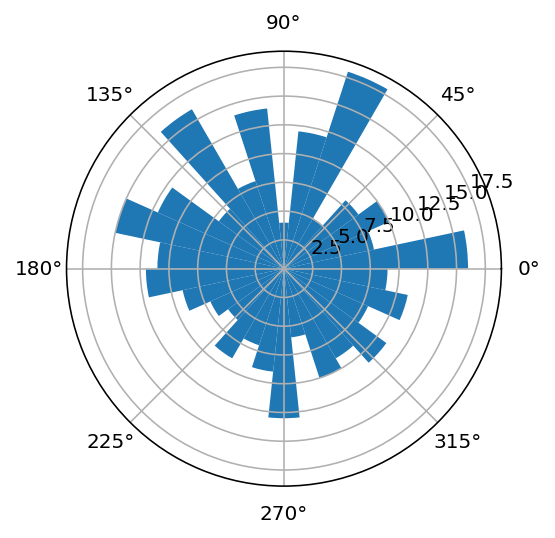

In [48]:
ax = plt.subplot(111, polar=True)
plothist(hist9);